In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import anndata as ad
import squidpy as sq
import importlib as imp
import h5py
from tqdm import tqdm

In [2]:
%%time
data = 'F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/expression_matrix.hdf5'
data =  h5py.File(data, "r")
data = data['data']
adata_sc = ad.AnnData(X=np.array(data['counts']).T)
obs_names = data['samples']
var_names = data['gene']
del data
var_names = [i.decode('utf-8') for i in var_names]
obs_names = pd.Series(obs_names)
obs_names = obs_names.str.decode('utf-8')
obs_names = obs_names.tolist()
adata_sc.var_names = var_names
adata_sc.obs_names = obs_names
del var_names, obs_names

CPU times: total: 8min 55s
Wall time: 8min 55s


In [3]:
meta_data = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/metadata.csv', index_col=0, header=0)
map_df = pd.read_excel('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/merge_plan.xlsx', header=0)[:71]
map_dict = {k:v for k, v in zip(map_df['cell_type'], map_df['merge'])}
meta_data['cell_type'] = meta_data['cluster_label'].str.split('_').str[1]
meta_data['merge'] = meta_data['cell_type'].map(map_dict)
meta_data = meta_data[~meta_data['merge'].isna()]
type_list = sorted(list(meta_data['merge'].unique()))

In [4]:
count = meta_data['merge'].value_counts().values
n = 5500
count[count>n] = n
print(np.sum(count))

select_idx = []
for cell_type in type_list:
    type_idx = np.where(meta_data['merge']==cell_type)[0]
    if len(type_idx) > n:
        type_idx = np.random.choice(type_idx, n, replace=False)
    select_idx += [type_idx]
select_idx = np.concatenate(select_idx)
meta_data = meta_data.iloc[select_idx]

94957


In [9]:
meta_data.head()

,donor_sex_id,donor_sex_label,donor_sex_color,region_id,region_label,region_color,platform_label,cluster_order,cluster_label,cluster_color,...,cell_type_accession_id,cell_type_designation_color,cell_type_alt_alias_color,cell_type_alias_color,cell_type_accession_color,cortical_layer_label,cortical_layer_order,cortical_layer_color,cell_type,merge
sample_name,,,,,,,,,,,,,,,,,,,,,
GCATGCGTCTTGAGGT-L8TX_180221_01_F12,1,F,#565353,28,HIP,#8DC63F,10X,376,376_Astro,#332F26,...,376,#332F26,#332F26,#332F26,#332F26,NaN,1,#FF7373,Astro,Astro
CAGAGAGTCCGCAAGC-L8TX_180221_01_G12,1,F,#565353,28,HIP,#8DC63F,10X,376,376_Astro,#332F26,...,376,#332F26,#332F26,#332F26,#332F26,NaN,1,#FF7373,Astro,Astro
GGAACTTTCTTGAGGT-L8TX_180221_01_G12,1,F,#565353,28,HIP,#8DC63F,10X,376,376_Astro,#332F26,...,376,#332F26,#332F26,#332F26,#332F26,NaN,1,#FF7373,Astro,Astro
TTCGAAGGTGTAACGG-L8TX_180221_01_G12,1,F,#565353,28,HIP,#8DC63F,10X,376,376_Astro,#332F26,...,376,#332F26,#332F26,#332F26,#332F26,NaN,1,#FF7373,Astro,Astro
ACGCCAGTCAGGCAAG-L8TX_180406_01_F06,2,M,#ADC4C3,28,HIP,#8DC63F,10X,376,376_Astro,#332F26,...,376,#332F26,#332F26,#332F26,#332F26,NaN,1,#FF7373,Astro,Astro


In [10]:
adata_sc = adata_sc[meta_data.index]
adata_sc.obs = meta_data

In [11]:
adata_sc.write('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/expression_matrix_filter.h5ad')

In [2]:
%%time
adata_sc = sc.read_h5ad('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/expression_matrix_filter.h5ad')

CPU times: total: 3.86 s
Wall time: 8.06 s


In [4]:
adata_sc.obs['merge'].value_counts()
adata_sc.obs['merge'].value_counts().to_csv('results/mouse brain/cell_count_sc.csv')

In [5]:
adata_sc_own = sc.read_h5ad('F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad')

In [6]:
adata_sc_own_copy = adata_sc_own.copy()

In [7]:
type_merge = ['Macrophage', 'Neutrophil', 'Microglia', 'DAM', 'BCell', 'TCell']
select_idx = np.array([i for i, cell_type in enumerate(adata_sc_own.obs['majortype']) if cell_type in type_merge])

In [8]:
adata_sc_own = adata_sc_own[select_idx]
adata_sc_own.obs['majortype'].unique()

array(['Microglia', 'BCell', 'TCell', 'Macrophage', 'DAM', 'Neutrophil'],
      dtype=object)

In [9]:
n_own = len(adata_sc_own)
n_mousebrain = len(adata_sc)

In [10]:
adata_sc_merge = ad.concat([adata_sc_own, adata_sc_own_copy, adata_sc_own_copy, adata_sc_own_copy])[:n_own+n_mousebrain]

anndata.py (1830): Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [14]:
adata_sc_merge.obs_names = np.concatenate([np.array(adata_sc_own.obs_names), np.array(adata_sc.obs_names)])

anndata.py (1830): Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
adata_sc_merge.obs.iloc[n_own:] = 0
adata_sc_merge.obs.iloc[n_own:, adata_sc_merge.obs.columns.get_loc('orig.ident')] = 'mouse brain'
adata_sc_merge.obs.iloc[n_own:, adata_sc_merge.obs.columns.get_loc('majortype')] = adata_sc.obs['merge']
adata_sc_merge.obs.iloc[n_own:, adata_sc_merge.obs.columns.get_loc('decon')] = adata_sc.obs['merge']
adata_sc_merge.obs.iloc[n_own:, adata_sc_merge.obs.columns.get_loc('doublet_finder')] = '0'
adata_sc_merge.obs.iloc[n_own:, adata_sc_merge.obs.columns.get_loc('CellName')] = '0'

In [16]:
adata_sc_merge.obs[n_own-10:n_own+10]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,age,gender,genotype,group,RNA_snn_res.0.5,seurat_clusters,...,CellName,nUMI.total,nGene,percent.mito,percent.spikeIn,X,Y,ClusterRes,majortype,decon
NCF64_TTTGACTTCACATTGA-1,NCF64,3290.0,1666,2.066869,2,1,1,5,5,5,...,NCF64,3290.0,1666,2.066869,0.0,8.582665,-3.210748,22,TCell,CD8T_Effector
NCF64_TTTGACTTCCTAAGAC-1,NCF64,2291.0,1316,1.178525,2,1,1,5,5,5,...,NCF64,2291.0,1316,1.178525,0.0,7.197799,-7.055128,9,TCell,CD8T_Exhausted
NCF64_TTTGCATTCCATTACT-1,NCF64,6400.0,2595,5.468750,2,1,1,5,2,2,...,NCF64,6400.0,2595,5.468750,0.0,9.596614,5.753071,2,DAM,DAM
NCF64_TTTGCGACAGCTACGT-1,NCF64,3497.0,1925,1.258221,2,1,1,5,11,11,...,NCF64,3497.0,1925,1.258221,0.0,13.684250,6.067745,30,Microglia,Microglia
NCF64_TTTGGTAAGTAGCTTA-1,NCF64,4072.0,2113,2.750491,2,1,1,5,1,1,...,NCF64,4072.0,2113,2.750491,0.0,14.709769,6.655351,30,Microglia,Microglia
NCF64_TTTGTCTAGGAACGGT-1,NCF64,2843.0,1400,2.638058,2,1,1,5,23,23,...,NCF64,2843.0,1400,2.638058,0.0,12.450172,-4.774952,21,TCell,Treg
NCF64_TTTGTGAAGGTCCGTA-1,NCF64,2552.0,1469,0.862069,2,1,1,5,5,5,...,NCF64,2552.0,1469,0.862069,0.0,7.005984,-7.391496,9,TCell,CD8T_Exhausted
NCF64_TTTGTGGCAACGTGCT-1,NCF64,4868.0,2211,2.773213,2,1,1,5,1,1,...,NCF64,4868.0,2211,2.773213,0.0,11.451719,7.349648,30,Microglia,Microglia
NCF64_TTTGTGGCATTGTGTG-1,NCF64,8152.0,2768,7.323356,2,1,1,5,2,2,...,NCF64,8152.0,2768,7.323356,0.0,9.051647,5.708003,2,DAM,DAM
NCF64_TTTGTTGGTTGCAGTA-1,NCF64,8089.0,2902,4.969712,2,1,1,5,1,1,...,NCF64,8089.0,2902,4.969712,0.0,12.078207,5.996086,30,Microglia,Microglia


In [17]:
adata_sc_merge.obs['majortype'].value_counts().to_csv('results/mouse brain/cell_count_merge.csv')

In [18]:
common_gene = list(set(adata_sc.var_names).intersection(set(adata_sc_merge.var_names)))
adata_sc_merge = adata_sc_merge[:, common_gene]
adata_sc = adata_sc[:, common_gene]
adata_sc_own = adata_sc_own[:, common_gene]

In [19]:
X1 = adata_sc_own.X
X2 = adata_sc.X
X1 = X1.astype(np.int32)

In [21]:
X = np.vstack((X1, X2))
del X1, X2

In [22]:
adata_sc_merge.X = X
del X

In [23]:
del adata_sc, adata_sc_own_copy, adata_sc_own

In [24]:
adata_sc_merge.write('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/expression_matrix_merge.h5ad')

anndata.py (1222): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1222): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1222): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1222): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1222): Trying to modify attribute `.obs` of view, initializing view as actual.


In [25]:
%%time
adata_sc_merge = sc.read_h5ad('F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/expression_matrix_merge.h5ad')

CPU times: total: 8.16 s
Wall time: 17.9 s


In [26]:
adata_sc_merge.obs[n_own-10:n_own+10]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,age,gender,genotype,group,RNA_snn_res.0.5,seurat_clusters,...,CellName,nUMI.total,nGene,percent.mito,percent.spikeIn,X,Y,ClusterRes,majortype,decon
NCF64_TTTGACTTCACATTGA-1,NCF64,3290.0,1666,2.066869,2,1,1,5,5,5,...,NCF64,3290.0,1666,2.066869,0.0,8.582665,-3.210748,22,TCell,CD8T_Effector
NCF64_TTTGACTTCCTAAGAC-1,NCF64,2291.0,1316,1.178525,2,1,1,5,5,5,...,NCF64,2291.0,1316,1.178525,0.0,7.197799,-7.055128,9,TCell,CD8T_Exhausted
NCF64_TTTGCATTCCATTACT-1,NCF64,6400.0,2595,5.468750,2,1,1,5,2,2,...,NCF64,6400.0,2595,5.468750,0.0,9.596614,5.753071,2,DAM,DAM
NCF64_TTTGCGACAGCTACGT-1,NCF64,3497.0,1925,1.258221,2,1,1,5,11,11,...,NCF64,3497.0,1925,1.258221,0.0,13.684250,6.067745,30,Microglia,Microglia
NCF64_TTTGGTAAGTAGCTTA-1,NCF64,4072.0,2113,2.750491,2,1,1,5,1,1,...,NCF64,4072.0,2113,2.750491,0.0,14.709769,6.655351,30,Microglia,Microglia
NCF64_TTTGTCTAGGAACGGT-1,NCF64,2843.0,1400,2.638058,2,1,1,5,23,23,...,NCF64,2843.0,1400,2.638058,0.0,12.450172,-4.774952,21,TCell,Treg
NCF64_TTTGTGAAGGTCCGTA-1,NCF64,2552.0,1469,0.862069,2,1,1,5,5,5,...,NCF64,2552.0,1469,0.862069,0.0,7.005984,-7.391496,9,TCell,CD8T_Exhausted
NCF64_TTTGTGGCAACGTGCT-1,NCF64,4868.0,2211,2.773213,2,1,1,5,1,1,...,NCF64,4868.0,2211,2.773213,0.0,11.451719,7.349648,30,Microglia,Microglia
NCF64_TTTGTGGCATTGTGTG-1,NCF64,8152.0,2768,7.323356,2,1,1,5,2,2,...,NCF64,8152.0,2768,7.323356,0.0,9.051647,5.708003,2,DAM,DAM
NCF64_TTTGTTGGTTGCAGTA-1,NCF64,8089.0,2902,4.969712,2,1,1,5,1,1,...,NCF64,8089.0,2902,4.969712,0.0,12.078207,5.996086,30,Microglia,Microglia


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


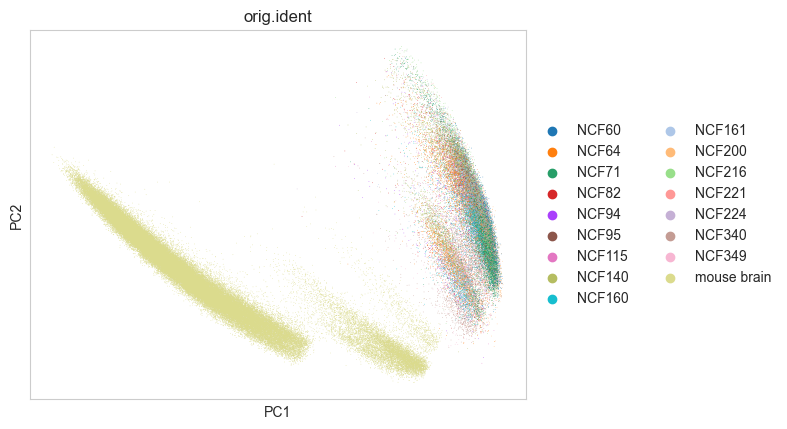

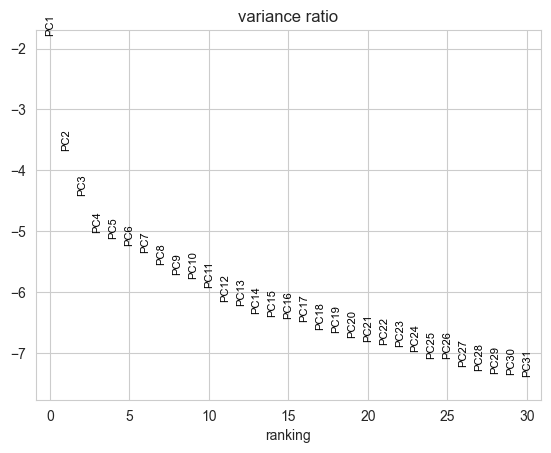

In [27]:
sc.pp.normalize_total(adata_sc_merge, target_sum=1e6)
sc.pp.log1p(adata_sc_merge)
adata_sc_merge.raw = adata_sc_merge
sc.tl.pca(adata_sc_merge, svd_solver='arpack')
sc.pl.pca(adata_sc_merge, color='orig.ident')
sc.pl.pca_variance_ratio(adata_sc_merge, log=True)

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


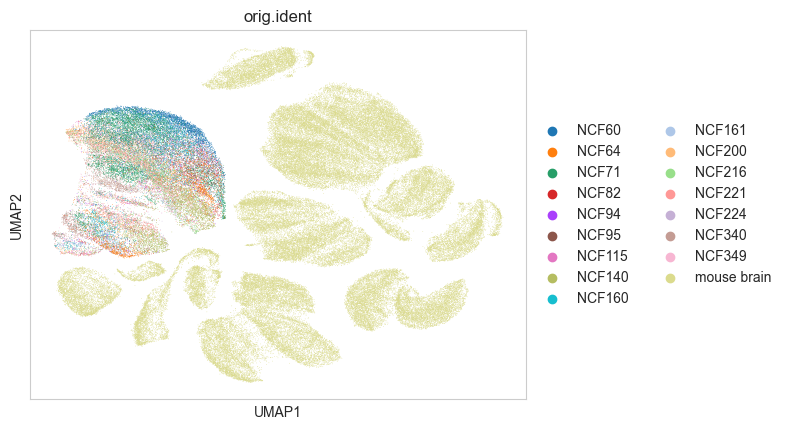

In [28]:
sc.pp.neighbors(adata_sc_merge, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sc_merge)
sc.pl.umap(adata_sc_merge, color='orig.ident')

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


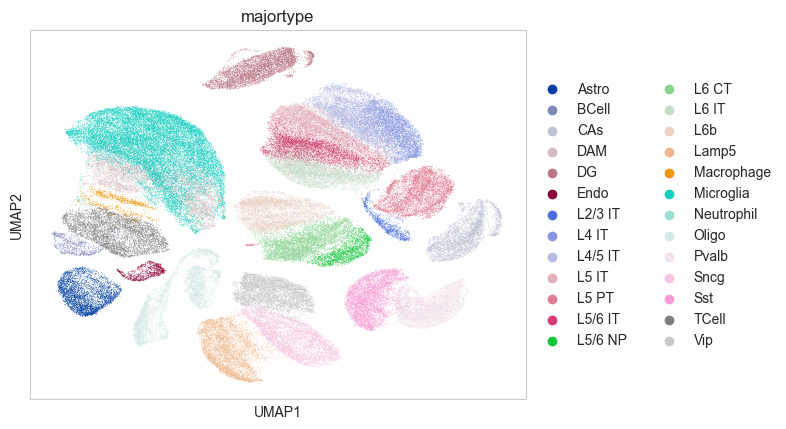

In [29]:
sc.pl.umap(adata_sc_merge, color='majortype')